# 1. Description

__Aim:__   
Practise with `time series EDA` and `time series feature engineering`   

__Case:__   
Epileptic Seizure Recognition (Classification) based on brain electroencefalography (EEG) results. See details [here](https://archive.ics.uci.edu/dataset/388/epileptic+seizure+recognition). An epilepsy seizure is characterized by abnormal brain activity, which can be detected using EEG.

__Plan:__   
1. EDA and target transformation (epileptic/not) 
2. Stratified split train-test.
3. Baseline.
4. Feature engineering: Fast-Fourier Transformation (FFT), Wavelets, TimeSeries feature autogeneration.
5. Train-test new model.

# 2. About data   
Info from [here](https://archive.ics.uci.edu/dataset/388/epileptic+seizure+recognition).

__Additional Variable Information__   

The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds.    

We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}.   

The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178     

y contains the category of the 178-dimensional input vector. Specifically y in {1, 2, 3, 4, 5}:    

* 5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open 

* 4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed 

* 3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area 

* 2 - They recorder the EEG from the area where the tumor was located 

* 1 - Recording of seizure activity    

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

# 3. Imports

In [4]:
import pandas as pd
import numpy as np
from detect_peaks import detect_peaks

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import tsfel

import pywt

Custom

In [32]:
from models.model import run_baseline
from feature_preproc.fft_psd_funcs import get_values, get_fft_values, get_psd_values, extract_features_labels
from feature_preproc.wavelet_funcs import get_uci_har_features

# 4. Global params

In [5]:
# Matplotlib params
rcParams['figure.figsize'] = 24, 8
plt.set_loglevel('WARNING')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

sns.set_theme()
BASE_CONTEXT = 'fivethirtyeight'

# Plot
SHOW_ROWS = 600

# See palette
PALETTE = sns.color_palette()
print(PALETTE.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


In [6]:
SEED = 42
TEST_RATIO = 0.2

DATA_FOLDER = "./data/eeg/"

# FFT and PSD
DENOMINATOR = 10
PEAKS_PERCENTILE = 5
NO_PEAKS = 5 # Судя по графикам больше не надо

# Wavelets
WAVELETNAME = 'bior1.5' # 'rbio3.1', 'coif17', 'db16', 'sym14', 'bior1.5'

# Autogenerate features
CFG_FILE = tsfel.get_features_by_domain() # tsfel.get_features_by_domain('temporal')
SAMPLING_FREQ = 50

# 5. Download data

In [7]:
df_data_raw = pd.read_csv(DATA_FOLDER + "Epileptic_Seizure_Recognition.csv")

# 6. EDA

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

Original dataset:
* 500 persons
* 23 chunks
* 178 points for 1 second

Therefore 500*23 = 11 500 rows with 178 points

### Prepare data

In [8]:
df_data_raw.set_index("Unnamed", inplace=True, drop=True)
df_data_raw.index.name = "id"
df_data_raw_type = {col: 'int' for col in df_data_raw.columns}

df_data_raw = df_data_raw.astype(df_data_raw_type)
df_data_raw.columns = df_data_raw.columns.str.lower()


y_name = "epileptic"
df_data_raw[y_name] = df_data_raw["y"].apply(lambda x: True if x == 1 else False)
df_data_raw.drop("y", axis=1, inplace=True)
df_data_num_cols = df_data_raw.columns[df_data_raw.columns != y_name]

C:\Users\parshin_sa2\AppData\Local\Temp\ipykernel_13176\2221711768.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data_raw[y_name] = df_data_raw["y"].apply(lambda x: True if x == 1 else False)


In [9]:
t_n = 1                  # signal time in seconds
N = df_data_raw.shape[1] # signal points
T = t_n / N              # signal periond
f_s = 1 / T              # frequency Hz
SAMPLE_RATE = 1 / f_s

### Explore data

In [10]:
def get_class_balance(df: pd.Series):
    print("Class balance, non-epileptic:", df[df == False].count() / df.count() * 100, "%")

In [11]:
print("Minimum vals:", df_data_raw.loc[:,df_data_num_cols].min().min())
print("Minimum vals:", df_data_raw.loc[:,df_data_num_cols].max().max())
print("Mean and std vals:", df_data_raw.loc[:,df_data_num_cols].mean().mean().round(2), "+-", df_data_raw.loc[:,df_data_num_cols].mean().std().round(2))
get_class_balance(df_data_raw[y_name])
print("General info")
df_data_raw.describe().agg("mean", axis=1)

Minimum vals: -1885
Minimum vals: 2047
Mean and std vals: -7.72 +- 2.02
Class balance, non-epileptic: 80.0 %
General info


count    11500.000000
mean        -7.722436
std        164.547935
min      -1812.500000
25%        -53.485955
50%         -7.314607
75%         36.417135
max       1737.640449
dtype: float64

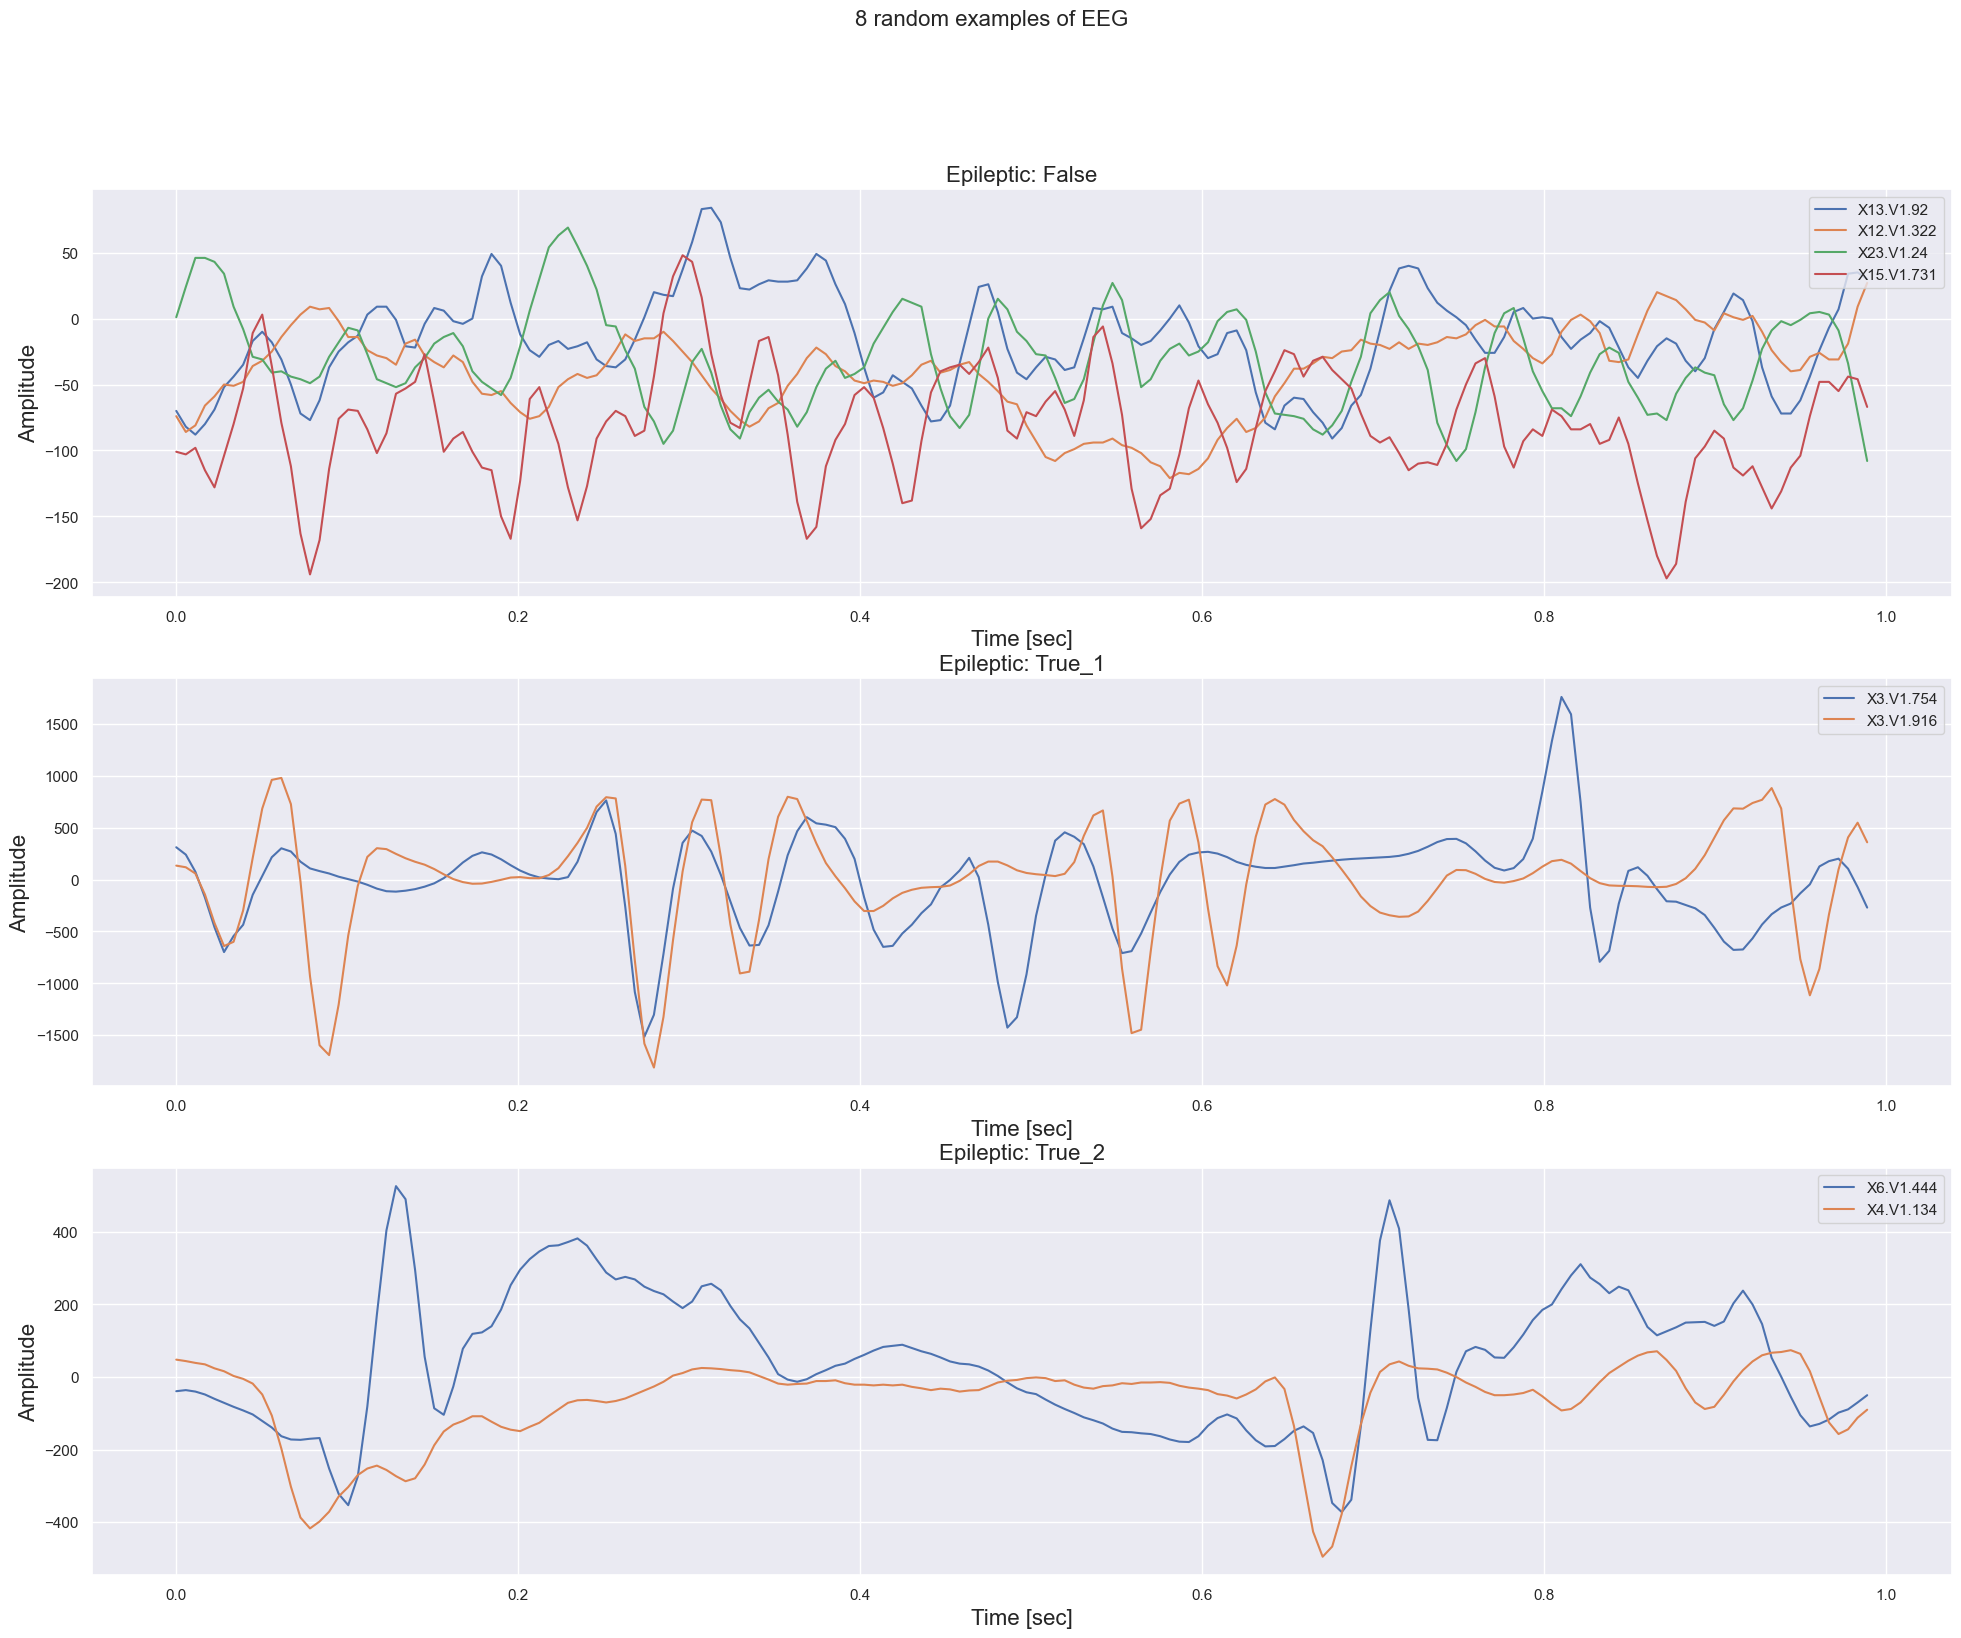

In [12]:
signals_to_show = {"Epileptic: False": ["X13.V1.92", "X12.V1.322", "X23.V1.24", "X15.V1.731"],
                   "Epileptic: True_1": ["X3.V1.754", "X3.V1.916"],
                   "Epileptic: True_2": ["X6.V1.444", "X4.V1.134"]}
xlabel = 'Time [sec]'
ylabel = 'Amplitude'

f, axarr = plt.subplots(nrows=len(signals_to_show), ncols=1, figsize=(24,18))
f.suptitle("8 random examples of EEG", fontsize=16)

x_values = np.array([SAMPLE_RATE * kk for kk in range(0,len(df_data_num_cols))])
 
for plot_no, col_key in zip(range(0,len(signals_to_show)), signals_to_show):
 
    # label = labels[plot_no]
    axtitle = col_key
    ax = axarr[plot_no]
    ax.set_title(axtitle, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    for i, row_name in enumerate(signals_to_show[col_key]):
        ax.plot(x_values, df_data_raw.loc[row_name, df_data_num_cols].values, linestyle='-', color=PALETTE[i], label=row_name)
    ax.legend(loc="upper right")


Epileptic cases have visible differences:   
* Epileptic cases have unstable EEG.
* Epileptic cases have pauses in frequencies.

Let's analyse statistics data depending on epileptic/no case:

In [13]:
print("Epileptic: True\n", df_data_raw[df_data_raw[y_name] == True].describe().agg("mean", axis=1))
print("Epileptic: Fasle\n", df_data_raw[df_data_raw[y_name] == False].describe().agg("mean", axis=1))

Epileptic: True
 count    2300.000000
mean       -4.760684
std       341.012060
min     -1812.500000
25%      -175.125000
50%        -4.873596
75%       176.759831
max      1500.606742
dtype: float64
Epileptic: Fasle
 count    9200.000000
mean       -8.462874
std        68.939918
min      -612.106742
25%       -44.884831
50%        -7.452247
75%        27.858146
max      1461.848315
dtype: float64


Observed visble difference in data.

### Train-test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_data_raw.loc[:, df_data_raw.columns != y_name],
                                                    df_data_raw[y_name],
                                                    test_size=TEST_RATIO,
                                                    random_state=SEED,
                                                    stratify=df_data_raw[y_name])

In [15]:
# Check
get_class_balance(y_test)
get_class_balance(y_train)

Class balance, non-epileptic: 80.0 %
Class balance, non-epileptic: 80.0 %


# 7. Baseline

Let's choose __Accuracy__ metric.

In [16]:
%%time
run_baseline(X_train, y_train, X_test, y_test, SEED);

Accuracy on training set is : 100.00%
Accuracy on test set is : 97.57%
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      1840
        True       0.95      0.93      0.94       460

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.96      2300
weighted avg       0.98      0.98      0.98      2300

CPU times: total: 23.2 s
Wall time: 23.2 s


# 8. Model with FTT and Wavelet

## Plot FTT and PSD

C:\Users\parshin_sa2\AppData\Local\Temp\ipykernel_13176\1610557340.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
C:\Users\parshin_sa2\AppData\Roaming\Python\Python310\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 178, using nperseg = 178
  warnings.warn('nperseg = {0:d} is greater than input length '


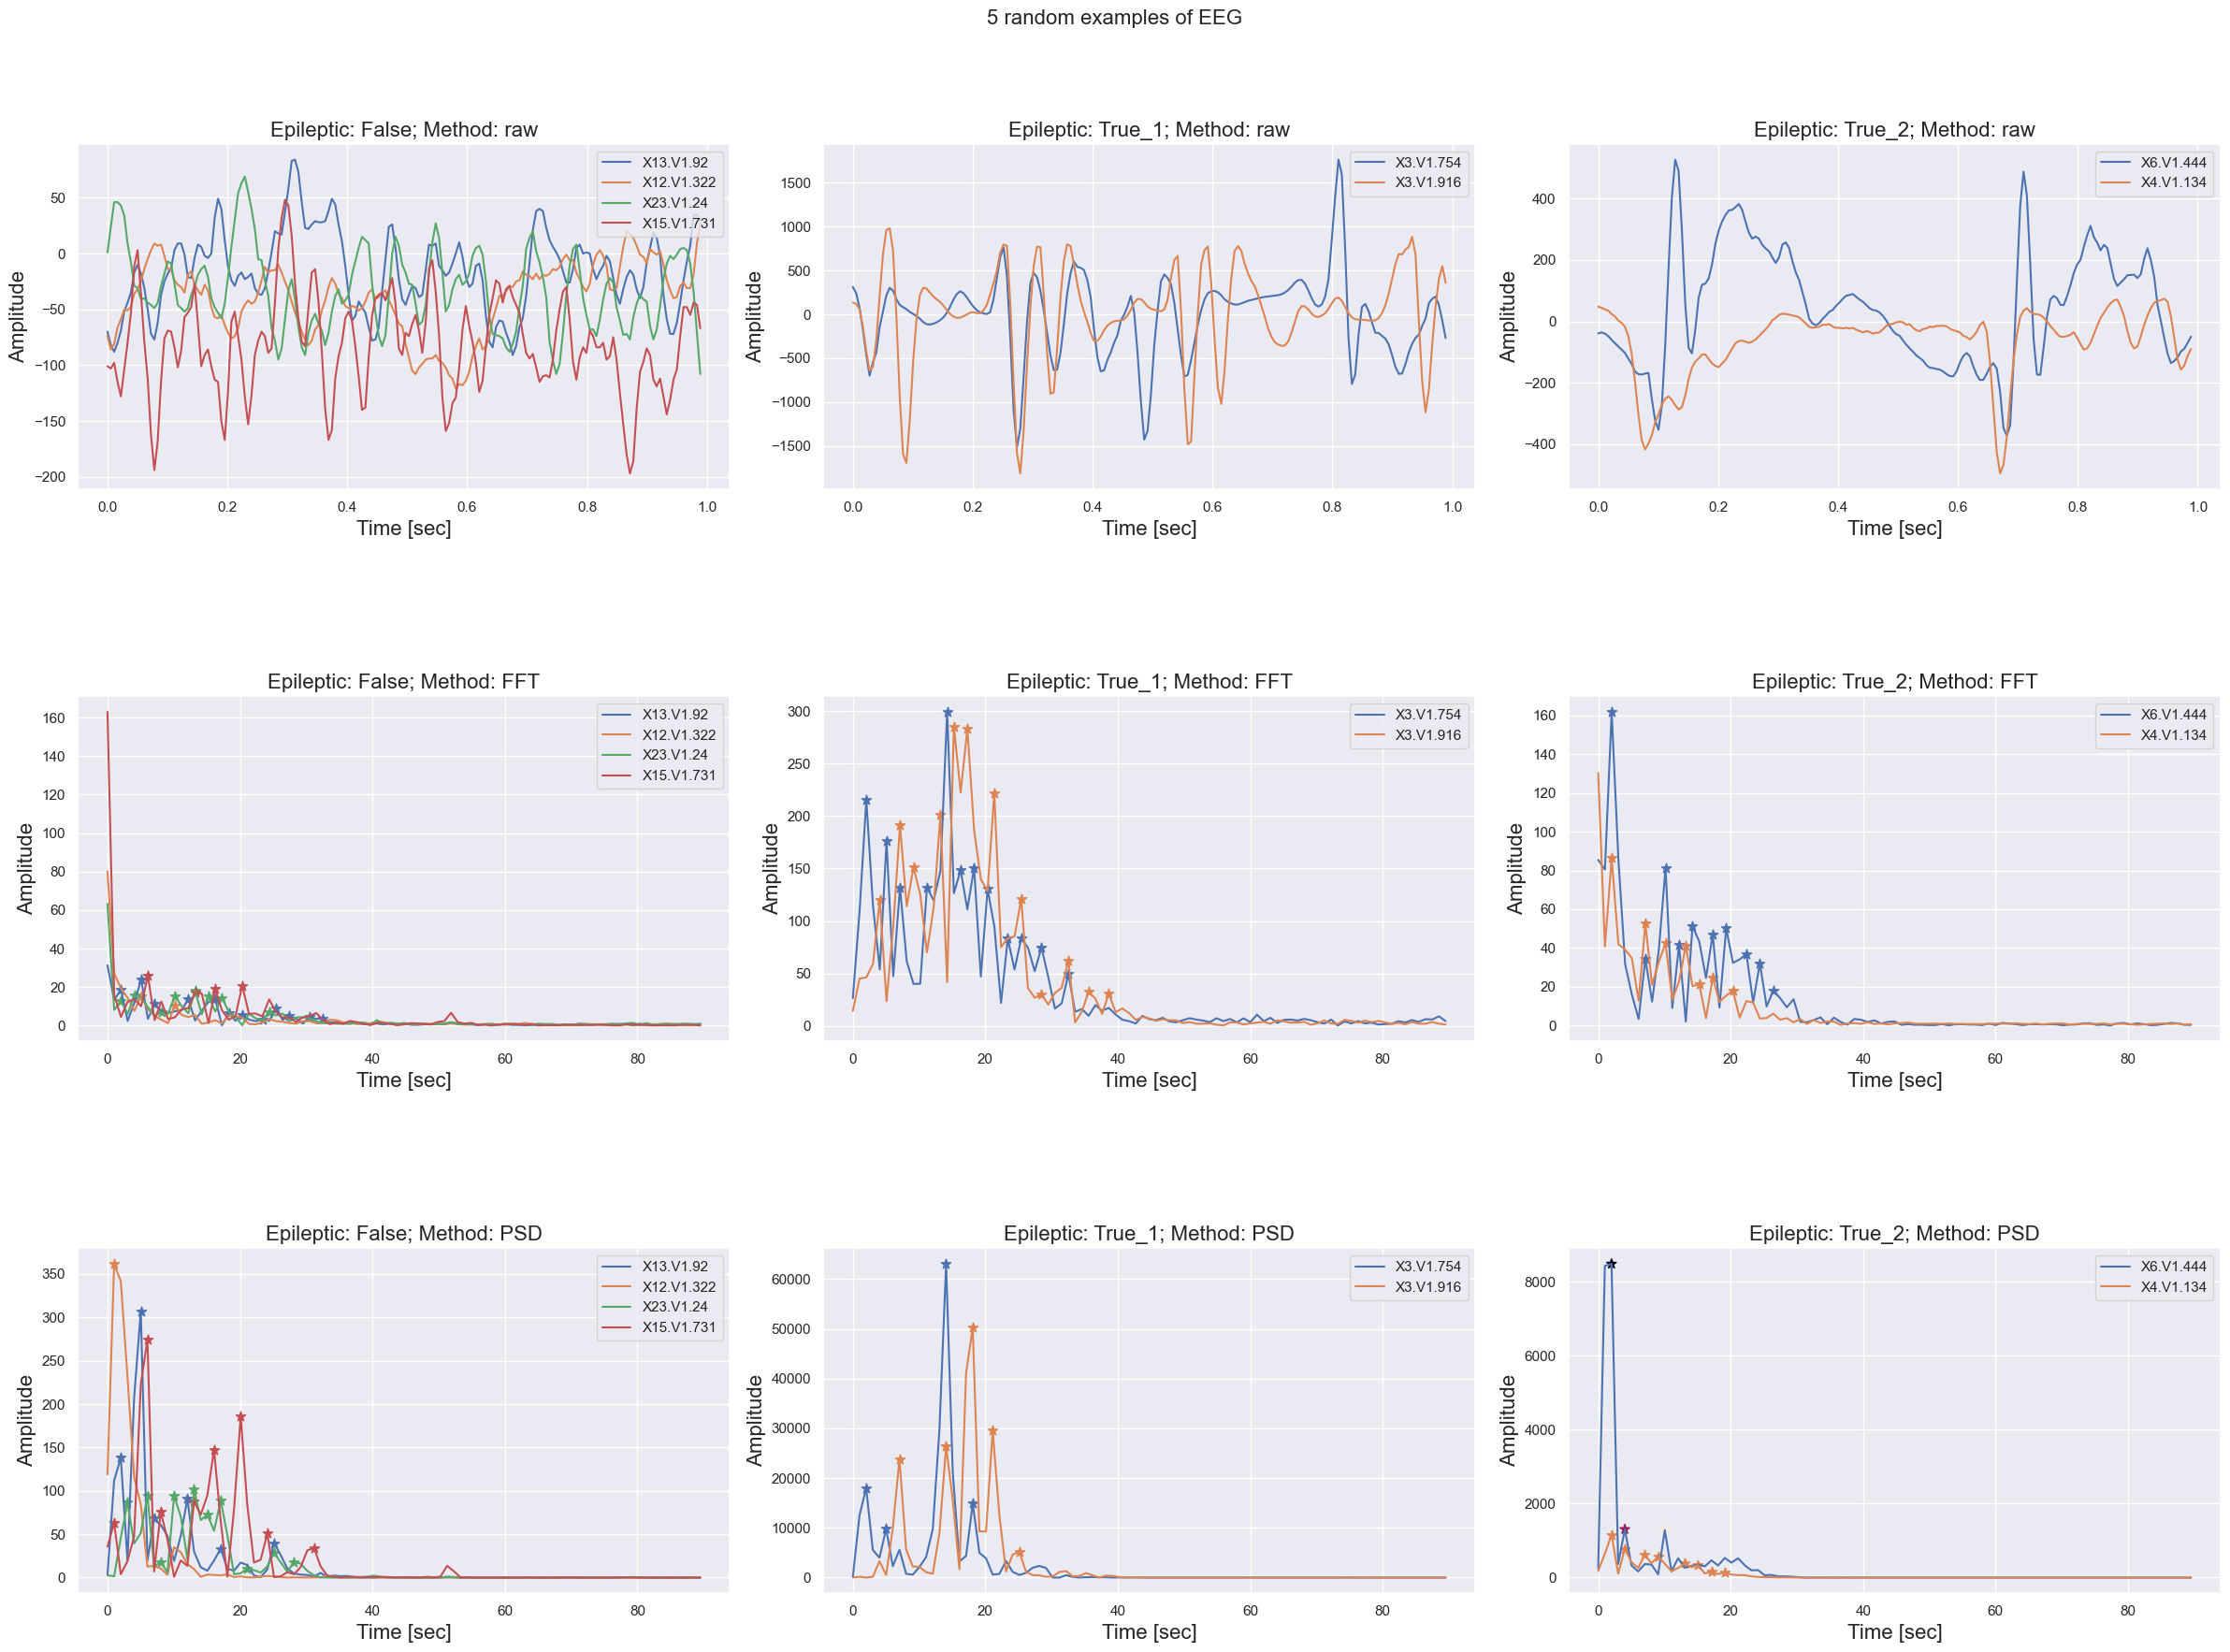

In [17]:
list_functions = {"raw": get_values,
                  "FFT": get_fft_values,
                  "PSD": get_psd_values}
signals_to_show = {"Epileptic: False": ["X13.V1.92", "X12.V1.322", "X23.V1.24", "X15.V1.731"],
                   "Epileptic: True_1": ["X3.V1.754", "X3.V1.916"],
                   "Epileptic: True_2": ["X6.V1.444", "X4.V1.134"]}
xlabel = 'Time [sec]'
ylabel = 'Amplitude'

f, axarr = plt.subplots(nrows=len(list_functions), ncols=len(signals_to_show), figsize=(24,18))
f.suptitle("5 random examples of EEG", fontsize=16)


for row_no, func_name in enumerate(list_functions):
    for col_no, col_key in zip(range(0,len(signals_to_show)), signals_to_show):

        axtitle = col_key + "; Method: " + func_name
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        
        for i, row_name in enumerate(signals_to_show[col_key]):
            
            signal = df_data_raw.loc[row_name, df_data_num_cols].values
            x_values, y_values = list_functions[func_name](signal, T, N, f_s, SAMPLE_RATE)
            ax.plot(x_values, y_values, linestyle='-', color=PALETTE[i], label=row_name)
            
            if row_no > 0:
                max_peak_height = 0.1 * np.nanmax(y_values)
                indices_peaks = detect_peaks(y_values, mph=max_peak_height)
                ax.scatter(
                    x_values[indices_peaks], 
                    y_values[indices_peaks], 
                    c=PALETTE[i], 
                    marker='*', 
                    s=60
                )
                
        ax.legend(loc="upper right")

plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

After data preprocessing it is also seen difference between epileptic and not.

### Get FTT and PSD features

In [18]:
X_train_ftt, y_train_ftt = extract_features_labels(X_train, y_train, T, N, f_s, DENOMINATOR, PEAKS_PERCENTILE, SAMPLE_RATE, NO_PEAKS)
X_test_ftt, y_test_ftt = extract_features_labels(X_test, y_test, T, N, f_s, DENOMINATOR, PEAKS_PERCENTILE, SAMPLE_RATE, NO_PEAKS)

  0%|          | 0/9200 [00:00<?, ?it/s]c:\Users\parshin_sa2\Desktop\Desktop\Education\ML Advanced\month_2\13_time_series_segmentation\hw\feature_preproc\fft_psd_funcs.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_of_labels.append(y[signal_no])


In [19]:
# For 2 preprocessings, 5 peaks and 2 coordinates have 20 features
X_train_ftt.shape, X_test_ftt.shape

((9200, 20), (2300, 20))

In [20]:
%%time
run_baseline(X_train_ftt, y_train_ftt, X_test_ftt, y_test_ftt, SEED);

Accuracy on training set is : 100.00%
Accuracy on test set is : 98.09%
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1840
        True       0.95      0.95      0.95       460

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300

CPU times: total: 4.97 s
Wall time: 4.99 s


__Prediction better Baseline by 0,5% by Accurancy__

## Wavelets

In [21]:
print("Number of wavelet's:", pywt.dwt_max_level(df_data_raw.shape[1], WAVELETNAME))

Number of wavelet's: 4


Several examples of wavelet's

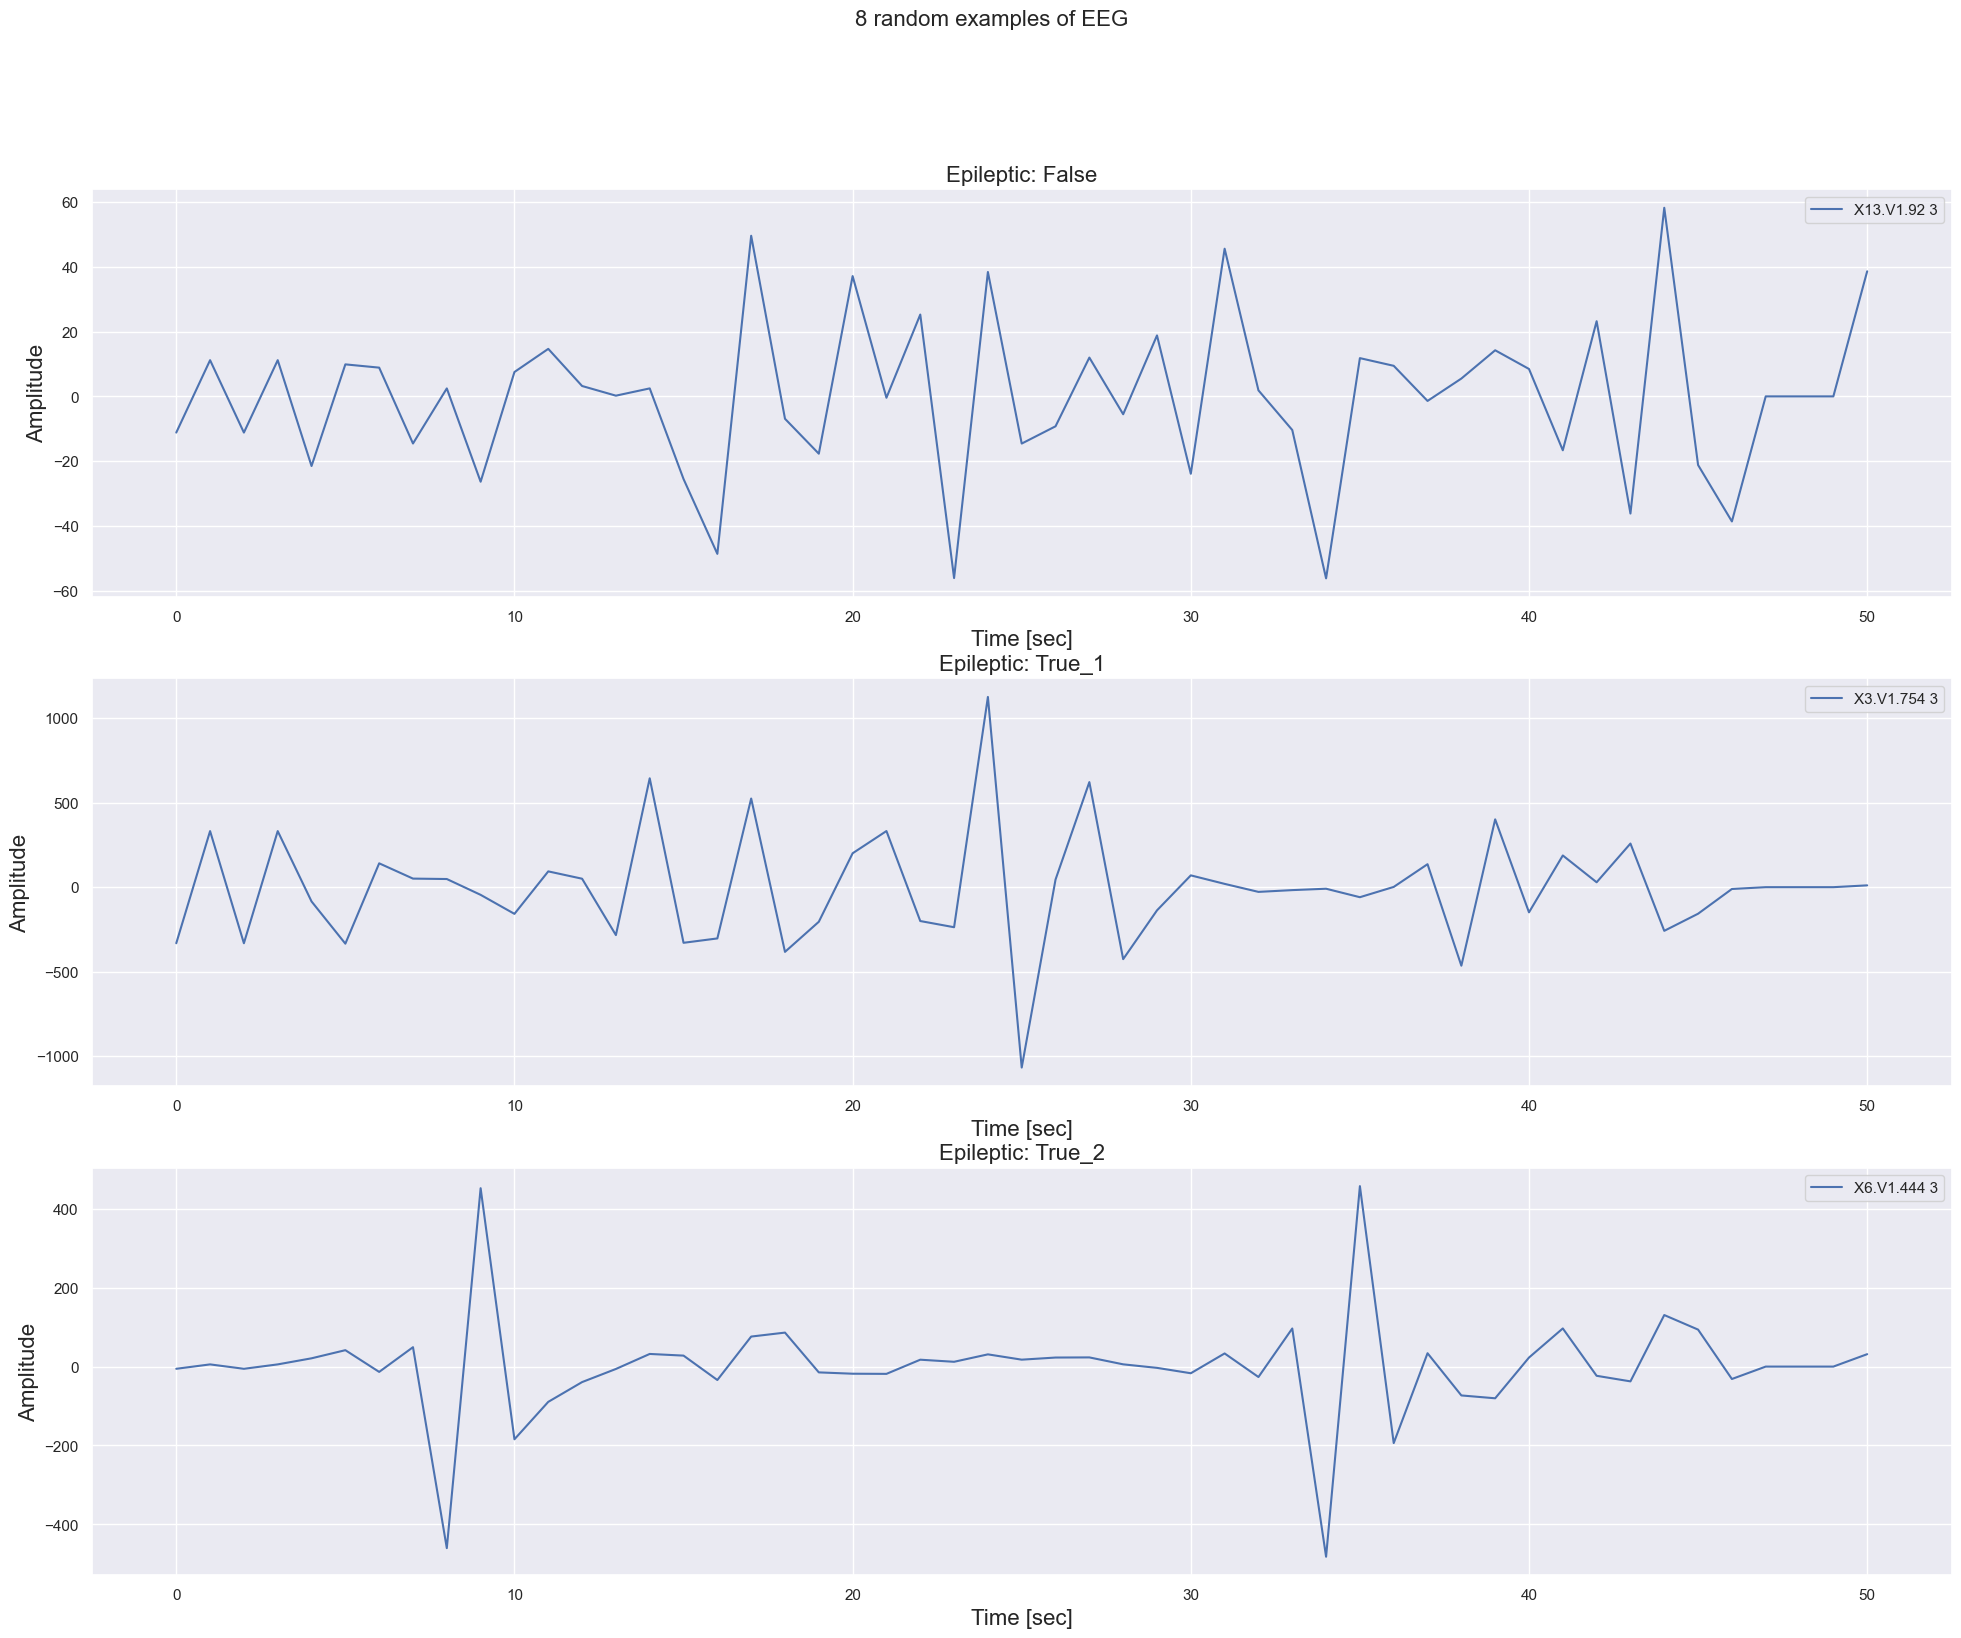

In [22]:
signals_to_show = {"Epileptic: False": ["X13.V1.92"],
                   "Epileptic: True_1": ["X3.V1.754"],
                   "Epileptic: True_2": ["X6.V1.444"]}
xlabel = 'Time [sec]'
ylabel = 'Amplitude'
wavelet_num = 3

f, axarr = plt.subplots(nrows=len(signals_to_show), ncols=1, figsize=(24,18))
f.suptitle("8 random examples of EEG", fontsize=16)
 
for plot_no, col_key in zip(range(0,len(signals_to_show)), signals_to_show):
 
    # label = labels[plot_no]
    axtitle = col_key
    ax = axarr[plot_no]
    ax.set_title(axtitle, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    # num_wavelets = pywt.dwt_max_level(df_data_raw.shape[1], WAVELETNAME)
    for i, row_name in enumerate(signals_to_show[col_key]):
        y_vals = pywt.wavedec(df_data_raw.loc[row_name, df_data_num_cols].values, WAVELETNAME)
        x_vals = [*range(len(y_vals[wavelet_num]))]
        ax.plot(x_vals, y_vals[wavelet_num], linestyle='-', color=PALETTE[i], label=row_name+" "+str(wavelet_num))
    ax.legend(loc="upper right")

In [23]:
X_train_wt, y_train_wt = get_uci_har_features(X_train, WAVELETNAME), y_train.copy()
X_test_wt, y_test_wt = get_uci_har_features(X_test, WAVELETNAME), y_test.copy()

In [24]:
# Have 4+1 wavelet's and 12 features, in total 60 
X_train_wt.shape, X_test_wt.shape

((9200, 60), (2300, 60))

In [25]:
%%time
run_baseline(X_train_wt, y_train_wt, X_test_wt, y_test_wt, SEED);

Accuracy on training set is : 100.00%
Accuracy on test set is : 98.57%
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1840
        True       0.97      0.96      0.96       460

    accuracy                           0.99      2300
   macro avg       0.98      0.97      0.98      2300
weighted avg       0.99      0.99      0.99      2300

CPU times: total: 9.33 s
Wall time: 9.37 s


__Predictions are better FFT and PSD by 0,5% by Accurancy__

## FTT, PSD and Wavelets

In [26]:
%%time

# Remove low variance features
selector = VarianceThreshold()
X_train_ftt_wt = selector.fit_transform(np.concatenate([X_train_wt, X_train_ftt], axis=1))
X_test_ftt_wt = selector.transform(np.concatenate([X_test_wt, X_test_ftt], axis=1))

print("Shape changes: \n", f"Was: {X_train_ftt_wt.shape[1]}", f"Now: {X_train_wt.shape[1] + X_train_ftt.shape[1]}")

run_baseline(X_train_ftt_wt, y_train_wt, X_test_ftt_wt, y_test_wt, SEED);

Shape changes: 
 Was: 80 Now: 80
Accuracy on training set is : 100.00%
Accuracy on test set is : 98.65%
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1840
        True       0.97      0.96      0.97       460

    accuracy                           0.99      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.99      0.99      0.99      2300

CPU times: total: 10.4 s
Wall time: 10.5 s


__Predictions are better by 0,08% related to Wavelets. VarianceThreshold() do not change number of features__

# 9. Autogenerate features

Other ways to get feautres do not work well than iterating over rows:/   

In [27]:
X_train_list = []
X_test_list = []
for example in X_train.index:
    X_train_list.append(tsfel.time_series_features_extractor(CFG_FILE, X_train.loc[example,:], fs=SAMPLING_FREQ, verbose=False))
X_train_tsfel = pd.concat(X_train_list).reset_index(drop=True)
for example in X_test.index:
    X_test_list.append(tsfel.time_series_features_extractor(CFG_FILE, X_test.loc[example,:], fs=SAMPLING_FREQ, verbose=False))
X_test_tsfel = pd.concat(X_test_list).reset_index(drop=True)

c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tsfel\feature_extraction\calc_features.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(signal_windows[0], pd.DataFrame):
c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tsfel\feature_extraction\calc_features.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(signal_windows[0], pd.DataFrame):
c:\Users\parshin_sa2\Miniconda3\envs\otus-ts\lib\site-packages\tsfel\feature_extraction\calc_features.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

In [28]:
X_train_tsfel.shape, X_test_tsfel.shape

((9200, 223), (2300, 223))

In [29]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train_tsfel)
X_train_tsfel.drop(corr_features, axis=1, inplace=True)
X_test_tsfel.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train_tsfel = selector.fit_transform(X_train_tsfel)
X_test_tsfel = selector.transform(X_test_tsfel)

# New shape
X_train_tsfel.shape, X_test_tsfel.shape

((9200, 151), (2300, 151))

In [31]:
run_baseline(X_train_tsfel, y_train, X_test_tsfel, y_test, SEED);

Accuracy on training set is : 100.00%
Accuracy on test set is : 98.87%
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1840
        True       0.97      0.97      0.97       460

    accuracy                           0.99      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.99      0.99      0.99      2300



# 10. Outcome

| Algorithm | Accuracy, % | Features |
|---|---|---|
| Baseline | 97,57 | 178 |
| FTT and PSD | 98,09 | 20 |
| Wavelets | 98,57 | 60 |
| FTT, PSD and Wavelets | 98,65 | 80 |
| tsfel ('temporal') | 97,87 | 9 |
| tsfel () | 98,87 | 151 |

The highest metric when using __tsfel__ with all features generation. Feature generation requires more time, than for other methods. But less code and analysis:-)   
Also __Wavelets__ shows small metric decrease when interpretation is better (wavelet - time series behaviour taking into account frequency and it's changing over time).